<a href="https://colab.research.google.com/github/AJAV-TIP/ApplicationExample/blob/main/Sensitivity_Zhang_et_al.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PCT Calculation for Mg at 100 °C as Reported by (Zhang et al., 2021)

Import common libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

Import library to retrieve molecular weight and density of constituent elements of the sample

In [ ]:
!pip install periodictable
import periodictable

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for periodictable: filename=periodictable-1.7.0-py3-none-any.whl size=752513 sha256=48e9ae17a3f0eea569a629996f8137ccacc93c0b887f500ab541bb501bd877bd
  Stored in directory: /root/.cache/pip/wheels/7e/19/a2/fef5d0ca2b1ad2b199e863a6e796ad9d5efc86563d80c91a0c
Successfully built periodictable


Import library to obtain compressibility factor or other thermodynamic properties from an Equation of State (EoS)

In [ ]:
!pip install CoolProp
import CoolProp.CoolProp as CP

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 14.7 MB/s eta 0:00:00


  Read pressure sensor data from a CSV file hosted in a public GitHub repository and store it in the objects `Pf` (Final Pressure) and `Pi` (Initial Pressure)

In [ ]:
url = ('https://raw.githubusercontent.com/AJAV-TIP/ApplicationExample/main/Zhang_et_al_2021.csv')
dataframe = pd.read_csv(url)
print(dataframe.info())

Pf = dataframe['Pf_(MPa)']
Pi = dataframe['Pi_(MPa)']

dataframe.head(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pi_(MPa)  24 non-null     float64
 1   Pf_(MPa)  24 non-null     float64
dtypes: float64(2)
memory usage: 512.0 bytes
None


,Pi_(MPa),Pf_(MPa)
0,0.000000,0.000001
1,0.009422,0.004886
2,0.022123,0.013800
3,0.028943,0.021579


Declare the elements of the material to be analyzed and retrieve the molecular weights and densities of the elements from the ‘Periodictable’ library.



In [ ]:
# List the symbols of the elements in your sample.
element_symbols = ['Mg']
Mw=[]
# Function to retrieve and store molecular weights in the vector.
def get_Mw(symbols):
    for symbol in symbols:
        element = periodictable.elements.symbol(symbol)
        Mw.append(element.mass)
# Function evaluation
get_Mw(element_symbols)

rho = []
# Function to retrieve and store solid state densities in the vector.
def get_rho(symbols):
    for symbol in symbols:
        element = periodictable.elements.symbol(symbol)
        rho.append(element.density)

get_rho(element_symbols)

# Results of consult at the Periodic table library
Mw_H2 = 2*periodictable.elements.symbol('H').mass
rho_H = periodictable.elements.symbol('H').density

print("Elements densities",rho,"g/cm^3")
print("Molecular weights",Mw,"g/mol")
print("H density",rho_H,"g/cm^3")
print("H2 molecular weight",Mw_H2,"g/mol")

Elements densities [1.738] g/cm^3
Molecular weights [24.305] g/mol
H density 0.0708 g/cm^3
H2 molecular weight 2.01588 g/mol


The sample weight is included, along with the coefficients of the elements that make up the sample, and the initial mass fractions are calculated

In [ ]:
m_host = 0.07 # g of sample
Mw = np.array(Mw)
rho = np.array(rho)
Coeff = np.array([1]) # coefficients of the elements that make up the sample
Mw_host = np.dot(Mw,Coeff) # molecular weight of the sample
w_i = Mw*Coeff/Mw_host # initial mass fractions

Insert the calibrated volumes

In [ ]:
V_rev = 12.098 #Reference volume Z.I
V_tube = 8.823 #Tube volume Z.II
V_sc = 2.91 # Sample cell volume Z.III

Insert temperatures

In [ ]:
T_rev = 298 # Reference  T (K) Z.I
T_tube = 298 # Tubes  T (K) Z.I
T_sc = 373 # Sample cell  T (K) Z.I

In [ ]:
dfX = pd.DataFrame(index=range(len(Pi)),columns=['Corrected','Den', 'Vol'])

Calculate hydrogen uptake in wt%

In [ ]:
rho_x = np.zeros(len(Pi))
V_DC = np.zeros(len(Pi))
m_x = np.zeros(len(Pi))
n_sor = np.zeros(len(Pi))
X = np.zeros(len(Pi))

rho_x[0] = 1/np.sum(np.append(w_i/rho,0)) # density of the sample at initial time Eq. 12 in Zhu et al. 2022
m_x[0] = m_host # mass of the sample at initial time

for i in range(1,len(Pi)):
    V_DC[i] = V_sc-(m_x[i-1]/rho_x[i-1]) # Volumen dead cell Eq. 10 in Zhu et al. 2022

    T1 = Pi[i]/((CP.PropsSI('Z', 'T', T_rev , 'P', Pi[i]*1e6, 'Hydrogen'))*T_rev) # Six fraction terms of Eq. 18 in Zhu et al. 2022
    T2 = Pf[i]/((CP.PropsSI('Z', 'T', T_rev , 'P', Pf[i]*1e6, 'Hydrogen'))*T_rev)
    T3 = Pf[i-1]/((CP.PropsSI('Z', 'T', T_tube , 'P', Pf[i-1]*1e6, 'Hydrogen'))*T_tube)
    T4 = Pf[i]/((CP.PropsSI('Z', 'T', T_tube , 'P', Pf[i]*1e6, 'Hydrogen'))*T_tube)
    T5 = Pf[i-1]/((CP.PropsSI('Z', 'T', T_sc , 'P', Pf[i-1]*1e6, 'Hydrogen'))*T_sc)
    T6 = Pf[i]/((CP.PropsSI('Z', 'T', T_sc , 'P', Pf[i]*1e6, 'Hydrogen'))*T_sc)

    n_sor[i] = (T1-T2)*V_rev + (T3-T4)*V_tube + (T5-T6)*V_DC[i] # Number of absorbed moles Eq. 18 in Zhu et al. 2022
    m_x[i] = m_host + n_sor[i-1]*Mw_host # Mass of the sample at time i Eq. 11 in Zhu et al. 2022

    rho_x[i] = 1/np.sum(np.append((w_i/rho)*m_host/m_x[i],n_sor[i]*Mw_H2/(rho_H*m_x[i]))) # Computational density of the sample Eq. 12 in Zhu et al. 2022
    X[i] = n_sor[i]*Mw_H2*100/(m_host+n_sor[i]*Mw_H2) # Gravimetric storage capacity Eq. 19 in Zhu et al. 2022

dfX.Corrected = pd.DataFrame(X)
dfX.Corrected

0     0.000000
1     0.005584
2     0.015374
3     0.025195
4     0.225885
5     0.626438
6     1.035520
7     1.427045
8     1.844504
9     2.227195
10    2.618577
11    3.018491
12    3.401225
13    3.810216
14    4.218808
15    4.618904
16    5.001636
17    5.427846
18    5.810393
19    6.184731
20    6.515393
21    6.542434
22    6.542323
23    6.551642
Name: Corrected, dtype: float64

In [ ]:
rho_x = np.zeros(len(Pi))
V_DC = np.zeros(len(Pi))
m_x = np.zeros(len(Pi))
n_sor = np.zeros(len(Pi))
X = np.zeros(len(Pi))

rho_x[0] = 1/np.sum(np.append(w_i/rho,0)) # density of the sample at initial time Eq. 12 in Zhu et al. 2022
m_x[0] = m_host # mass of the sample at initial time

for i in range(1,len(Pi)):
    V_DC[i] = V_sc-(m_x[i-1]/rho_x[0]) # Volumen dead cell Eq. 10 in Zhu et al. 2022

    T1 = Pi[i]/((CP.PropsSI('Z', 'T', T_rev , 'P', Pi[i]*1e6, 'Hydrogen'))*T_rev) # Six fraction terms of Eq. 18 in Zhu et al. 2022
    T2 = Pf[i]/((CP.PropsSI('Z', 'T', T_rev , 'P', Pf[i]*1e6, 'Hydrogen'))*T_rev)
    T3 = Pf[i-1]/((CP.PropsSI('Z', 'T', T_tube , 'P', Pf[i-1]*1e6, 'Hydrogen'))*T_tube)
    T4 = Pf[i]/((CP.PropsSI('Z', 'T', T_tube , 'P', Pf[i]*1e6, 'Hydrogen'))*T_tube)
    T5 = Pf[i-1]/((CP.PropsSI('Z', 'T', T_sc , 'P', Pf[i-1]*1e6, 'Hydrogen'))*T_sc)
    T6 = Pf[i]/((CP.PropsSI('Z', 'T', T_sc , 'P', Pf[i]*1e6, 'Hydrogen'))*T_sc)

    n_sor[i] = (T1-T2)*V_rev + (T3-T4)*V_tube + (T5-T6)*V_DC[i] # Number of absorbed moles Eq. 18 in Zhu et al. 2022
    m_x[i] = m_host + n_sor[i-1]*Mw_host # Mass of the sample at time i Eq. 11 in Zhu et al. 2022

    rho_x[i] = 1/np.sum(np.append((w_i/rho)*m_host/m_x[i],n_sor[i]*Mw_H2/(rho_H*m_x[i]))) # Computational density of the sample Eq. 12 in Zhu et al. 2022
    X[i] = n_sor[i]*Mw_H2*100/(m_host+n_sor[i]*Mw_H2) # Gravimetric storage capacity Eq. 19 in Zhu et al. 2022

dfX.Den = pd.DataFrame(X)
dfX.Den

0     0.000000
1     0.005584
2     0.015370
3     0.025187
4     0.225875
5     0.626327
6     1.035285
7     1.426841
8     1.844413
9     2.227020
10    2.618508
11    3.018570
12    3.400764
13    3.809781
14    4.218683
15    4.618904
16    5.001334
17    5.426999
18    5.810582
19    6.183492
20    6.512138
21    6.538669
22    6.539544
23    6.543641
Name: Den, dtype: float64

In [ ]:
rho_x = np.zeros(len(Pi))
V_DC = np.zeros(len(Pi))
m_x = np.zeros(len(Pi))
n_sor = np.zeros(len(Pi))
X = np.zeros(len(Pi))

rho_x[0] = 1/np.sum(np.append(w_i/rho,0)) # density of the sample at initial time Eq. 12 in Zhu et al. 2022
m_x[0] = m_host # mass of the sample at initial time

for i in range(1,len(Pi)):
    V_DC[i] = V_sc-(m_x[0]/rho_x[0]) # Volumen dead cell Eq. 10 in Zhu et al. 2022

    T1 = Pi[i]/((CP.PropsSI('Z', 'T', T_rev , 'P', Pi[i]*1e6, 'Hydrogen'))*T_rev) # Six fraction terms of Eq. 18 in Zhu et al. 2022
    T2 = Pf[i]/((CP.PropsSI('Z', 'T', T_rev , 'P', Pf[i]*1e6, 'Hydrogen'))*T_rev)
    T3 = Pf[i-1]/((CP.PropsSI('Z', 'T', T_tube , 'P', Pf[i-1]*1e6, 'Hydrogen'))*T_tube)
    T4 = Pf[i]/((CP.PropsSI('Z', 'T', T_tube , 'P', Pf[i]*1e6, 'Hydrogen'))*T_tube)
    T5 = Pf[i-1]/((CP.PropsSI('Z', 'T', T_sc , 'P', Pf[i-1]*1e6, 'Hydrogen'))*T_sc)
    T6 = Pf[i]/((CP.PropsSI('Z', 'T', T_sc , 'P', Pf[i]*1e6, 'Hydrogen'))*T_sc)

    n_sor[i] = (T1-T2)*V_rev + (T3-T4)*V_tube + (T5-T6)*V_DC[i] # Number of absorbed moles Eq. 18 in Zhu et al. 2022
    m_x[i] = m_host + n_sor[i-1]*Mw_host # Mass of the sample at time i Eq. 11 in Zhu et al. 2022

    rho_x[i] = 1/np.sum(np.append((w_i/rho)*m_host/m_x[i],n_sor[i]*Mw_H2/(rho_H*m_x[i]))) # Computational density of the sample Eq. 12 in Zhu et al. 2022
    X[i] = n_sor[i]*Mw_H2*100/(m_host+n_sor[i]*Mw_H2) # Gravimetric storage capacity Eq. 19 in Zhu et al. 2022

dfX.Vol = pd.DataFrame(X)
dfX.Vol

0     0.000000
1     0.005584
2     0.015370
3     0.025186
4     0.225872
5     0.626321
6     1.035234
7     1.426755
8     1.844364
9     2.226914
10    2.618461
11    3.018626
12    3.400423
13    3.809448
14    4.218586
15    4.618904
16    5.001090
17    5.426301
18    5.810737
19    6.182449
20    6.509370
21    6.535402
22    6.536888
23    6.535926
Name: Vol, dtype: float64

Generate plot

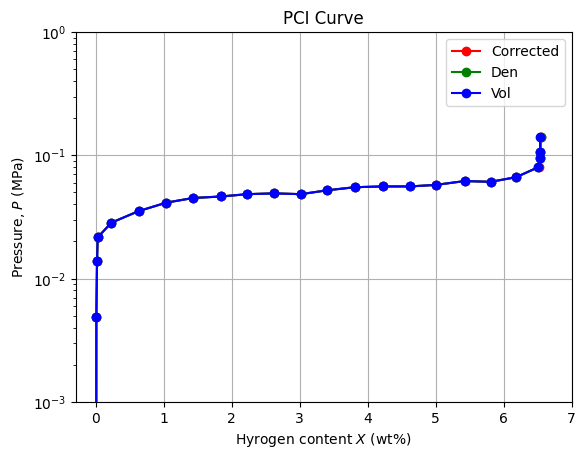

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel('Hyrogen content $X$ (wt%)')
ax.set_ylabel('Pressure, $P$ (MPa)')
ax.set_xlim([-0.3,7])
ax.set_ylim([0.001,1])
ax.set_yscale('log')
ax.grid(True)

ax.plot(dfX.Corrected,Pf,'o-',color = 'r', label = 'Corrected')
ax.plot(dfX.Den,Pf,'o-',color = 'g', label = 'Den')
ax.plot(dfX.Vol,Pf,'o-',color = 'b', label = 'Vol')

ax.legend()
ax.set_title('PCI Curve')
plt.show()

In [ ]:
dfX

,Corrected,Den,Vol
0,0.000000,0.000000,0.000000
1,0.005584,0.005584,0.005584
2,0.015374,0.015370,0.015370
3,0.025195,0.025187,0.025186
4,0.225885,0.225875,0.225872
5,0.626438,0.626327,0.626321
6,1.035520,1.035285,1.035234
7,1.427045,1.426841,1.426755
8,1.844504,1.844413,1.844364
9,2.227195,2.227020,2.226914
